# Animals classification

In deze notebook wordt er geprobeerd om verschillende images van dieren te voorspellen. De dieren komen vanuit de cifar-10 dataset. Dit wordt gedaan met behulp van CNN.

note: de images zijn gedownload. Er wordt verwacht dat je een directory hebt aangemaakt met deze images in verschillende folders.

### Importeer libraries

In [3]:
import os
import time

import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, MaxPooling2D, UpSampling2D, Input, Conv2DTranspose, Activation, Lambda
from tensorflow.keras.utils import to_categorical

from keras import backend as K

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Bekijk welke devices beschikbaar zijn

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Maak de features en labels aan

In [2]:
BASE_PATH = './Animals-10/'

X = [] # features
y = [] # labels

animals = ['butterfly', 'cat', 'dog', 'horse', 'sheep'] # alle dieren in de directory

for subdir, _, files in os.walk(BASE_PATH):
    for file in files:
        filepath = subdir + os.sep + file

        if filepath.endswith(".jpg"): # er zijn jpeg en jpg afbeeldingen. Ik heb alleen de jpgs gepakt
            try:
                img = plt.imread(filepath)

                img = cv.resize(img, dsize=(128, 128)) # elke afbeelding even groot maken (100*100)
                #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # haal rgb weg
                # normaliseer
                img = img.astype(np.float32)
                img /= 255.0
                
                X.append(img)
                y.append(animals.index(file.split()[0]))
            except:
                pass

one-hot-encoding

In [5]:
y = to_categorical(y)

voorbeeld van de encoding

[0. 1. 0. 0. 0.]


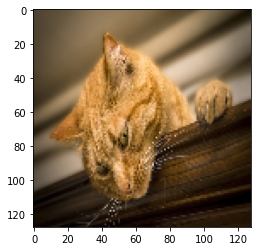

In [6]:
print(y[0])
plt.imshow(X[1])

verander de X en y naar numpy arrays

In [7]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((1238, 128, 128, 3), (1238, 5))

split data in train en test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train.shape, X_test.shape

((990, 128, 128, 3), (248, 128, 128, 3))

[array([0., 0., 0., 0., 1.], dtype=float32)]


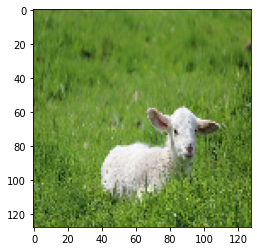

In [10]:
print([y_train[12]])
plt.imshow(X_train[12])

### Model

In [50]:
def create_lstm_model():
    model = Sequential()

    model.add(Conv2D(filters=64,kernel_size=(3, 3),activation='relu', input_shape=(128,128, 3)))
    model.add(MaxPooling2D(pool_size=2,strides=2))
    model.add(Conv2D(filters=64,kernel_size=3,padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2,strides=2))

    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation = 'softmax'))

    model.compile(optimizer='adam',
            metrics = ['accuracy'],
            loss = 'categorical_crossentropy')
    
    return model

def show_accuracy_results(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(title)

    ax1.set_title('Accuracy')
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set(xlabel='epoch', ylabel='accuracy')

    ax2.set_title('model loss')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set(xlabel='epoch', ylabel='loss')

    plt.tight_layout()
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

##### CPU LSTM

In [52]:
with tf.device("/cpu:0"):
    cpu_model = create_lstm_model()

    start = time.time()
    cpu_lstm_history = cpu_model.fit(X_train,y_train,epochs=10,batch_size = 32, validation_split=0.1)

    end = time.time()
    cpu_train_time = end - start
    print('\ntrain time: ', cpu_train_time)  

Train on 891 samples, validate on 99 samples


2022-04-29 13:31:55.681418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-29 13:31:55.868773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-04-29 13:31:55.937457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-29 13:31:55.976296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 5s 5ms/sample - loss: 1.1608 - accuracy: 0.4590 - val_loss: 0.9579 - val_accuracy: 0.4949
Epoch 2/10


2022-04-29 13:32:00.492940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 4s 5ms/sample - loss: 0.7014 - accuracy: 0.7059 - val_loss: 0.7684 - val_accuracy: 0.7071
Epoch 3/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.5466 - accuracy: 0.7856 - val_loss: 0.7084 - val_accuracy: 0.7172
Epoch 4/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.4861 - accuracy: 0.8215 - val_loss: 0.8755 - val_accuracy: 0.6667
Epoch 5/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.4633 - accuracy: 0.8350 - val_loss: 0.7417 - val_accuracy: 0.7273
Epoch 6/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.3509 - accuracy: 0.8822 - val_loss: 0.7432 - val_accuracy: 0.7778
Epoch 7/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.2865 - accuracy: 0.9035 - val_loss: 0.8803 - val_accuracy: 0.7273
Epoch 8/10
891/891 [==============================] - 4s 5ms/sample - loss: 0.2345 - accuracy: 0.9327 - val_loss: 0.8081 - val_accuracy: 0.8081
Epo

In [53]:
start = time.time()
loss, acc = cpu_model.evaluate(X_test,
                         y_test)
end = time.time()
cpu_lstm_test_time = end - start
print('test time: ', cpu_lstm_test_time)
print('acc: ', acc)

test time:  0.3845560550689697
acc:  0.766129


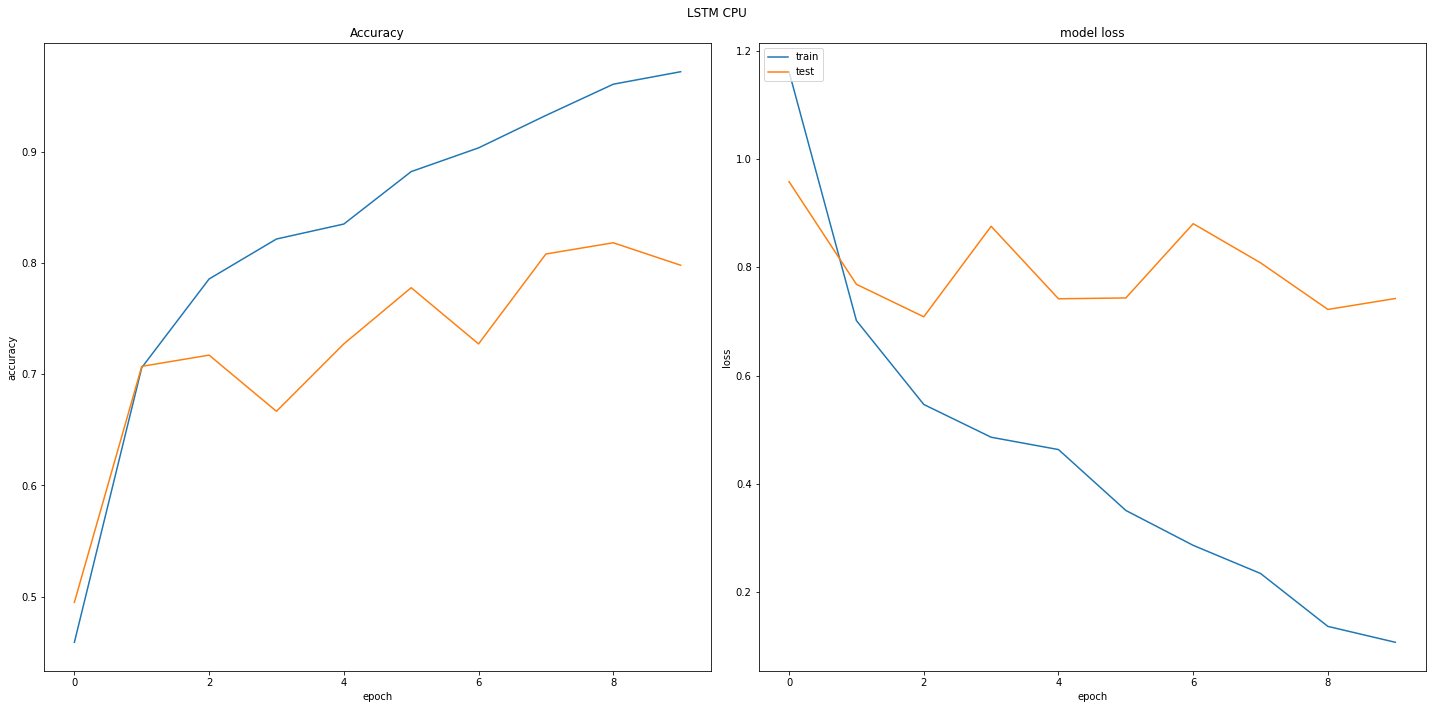

In [54]:
show_accuracy_results(cpu_lstm_history, 'LSTM CPU')

<mark>Insights</mark>

- Nog steeds ietjes overfit
- Loss aan het eind is wel veel.

##### GPU LSTM

In [55]:
with tf.device("/gpu:0"):
    gpu_model = create_lstm_model()

    start = time.time()
    gpu_lstm_history = gpu_model.fit(X_train,y_train,epochs=10,batch_size=32, validation_split=0.1)

    end = time.time()
    gpu_train_time = end - start
    print('\ntrain time: ', gpu_train_time) 

Train on 891 samples, validate on 99 samples


2022-04-29 13:32:54.081184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-29 13:32:54.282211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-04-29 13:32:54.432543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-29 13:32:54.472886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - ETA: 0s - loss: 1.2391 - accuracy: 0.4119

2022-04-29 13:32:57.265831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


891/891 [==============================] - 3s 3ms/sample - loss: 1.2391 - accuracy: 0.4119 - val_loss: 0.9307 - val_accuracy: 0.6162
Epoch 2/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.8364 - accuracy: 0.6431 - val_loss: 0.8636 - val_accuracy: 0.6566
Epoch 3/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.6237 - accuracy: 0.7621 - val_loss: 0.7967 - val_accuracy: 0.7071
Epoch 4/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.5827 - accuracy: 0.7778 - val_loss: 0.6887 - val_accuracy: 0.7172
Epoch 5/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.5006 - accuracy: 0.7991 - val_loss: 0.6967 - val_accuracy: 0.7273
Epoch 6/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.4297 - accuracy: 0.8316 - val_loss: 0.6812 - val_accuracy: 0.7576
Epoch 7/10
891/891 [==============================] - 2s 2ms/sample - loss: 0.4116 - accuracy: 0.8519 - val_loss: 0.7403 - val_accuracy: 0.7475
Epo

In [56]:
start = time.time()
loss, acc = gpu_model.evaluate(X_test,y_test)
end = time.time()
gpu_lstm_test_time = end - start
print('test time: ', gpu_lstm_test_time)
print('acc: ', acc)

test time:  0.3802478313446045
acc:  0.7862903


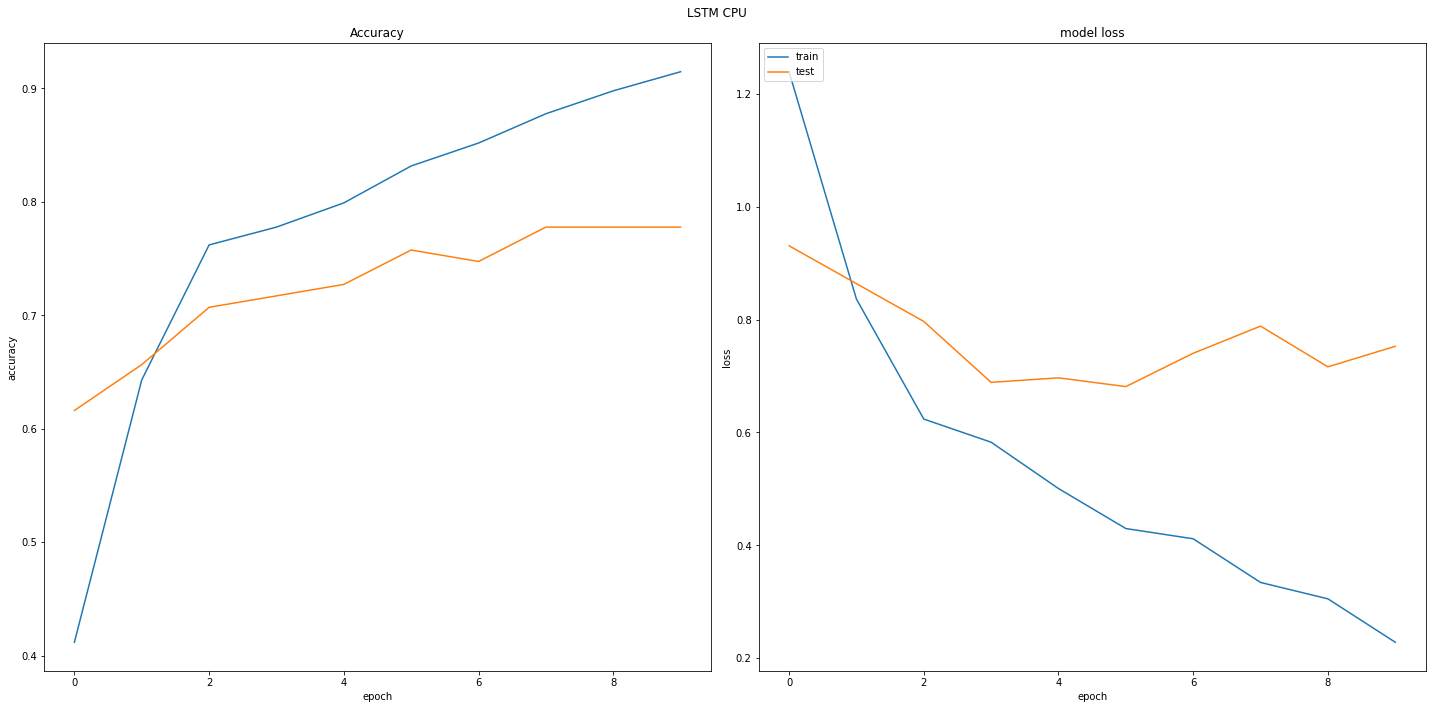

In [57]:
show_accuracy_results(gpu_lstm_history, 'LSTM CPU')

<mark>Insights</mark>

- Nog steeds ietjes overfit
- Loss aan het eind is wel veel. Wel minder dan CPU.

##### Dense Netwerk

In [63]:
X_train.shape

(990, 128, 128, 3)

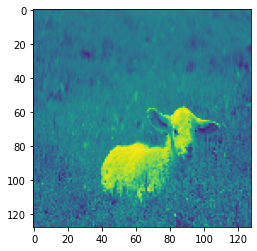

In [71]:
tet = cv.cvtColor(X_train[12], cv.COLOR_BGR2GRAY)

plt.imshow(tet)

In [86]:
X_train_grayscaled = []
X_test_grayscaled = []

for img in X_train:
    gray_scaled_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    X_train_grayscaled.append(gray_scaled_img)

for img in X_test:
    gray_scaled_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    X_test_grayscaled.append(gray_scaled_img)

X_train_grayscaled = np.array(X_train_grayscaled)
X_test_grayscaled = np.array(X_test_grayscaled)

In [89]:
X_train_grayscaled.shape, X_test_grayscaled.shape

((990, 128, 128), (248, 128, 128))

In [90]:
X_train_reshaped = X_train_grayscaled.reshape(990, 128*128)
X_test_reshaped = X_test_grayscaled.reshape(248, 128*128)

In [92]:
X_train_reshaped.shape, X_test_reshaped.shape

((990, 16384), (248, 16384))

In [108]:
model = Sequential()

model.add(Dense(128,activation = 'relu',input_shape=(128*128,)))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5,activation = 'softmax'))

model.compile(optimizer='adam',
            metrics = ['accuracy'],
            loss = 'categorical_crossentropy')

In [109]:
start = time.time()
history = model.fit(X_train_reshaped,y_train,epochs=10,batch_size = 32, validation_split=0.1)

end = time.time()
train_time = end - start
print('train time: ', train_time)

Epoch 1/10
 1/28 [>.............................] - ETA: 8s - loss: 1.6340 - accuracy: 0.2500

2022-04-28 20:27:54.983568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 1s 20ms/step - loss: 1.8230 - accuracy: 0.3625 - val_loss: 1.2137 - val_accuracy: 0.3636
Epoch 2/10
 6/28 [=====>........................] - ETA: 0s - loss: 1.2577 - accuracy: 0.3802

2022-04-28 20:27:55.570555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 0s 14ms/step - loss: 1.2599 - accuracy: 0.3951 - val_loss: 1.0656 - val_accuracy: 0.4242
Epoch 3/10
28/28 [==============================] - 0s 14ms/step - loss: 1.1620 - accuracy: 0.4501 - val_loss: 1.3626 - val_accuracy: 0.4040
Epoch 4/10
28/28 [==============================] - 0s 16ms/step - loss: 1.0659 - accuracy: 0.4691 - val_loss: 1.7683 - val_accuracy: 0.3636
Epoch 5/10
28/28 [==============================] - 0s 15ms/step - loss: 0.9970 - accuracy: 0.5129 - val_loss: 1.1601 - val_accuracy: 0.3838
Epoch 6/10
28/28 [==============================] - 0s 14ms/step - loss: 1.0390 - accuracy: 0.5084 - val_loss: 1.1594 - val_accuracy: 0.4444
Epoch 7/10
28/28 [==============================] - 0s 14ms/step - loss: 0.9443 - accuracy: 0.5657 - val_loss: 1.1075 - val_accuracy: 0.4747
Epoch 8/10
28/28 [==============================] - 0s 14ms/step - loss: 0.9208 - accuracy: 0.5589 - val_loss: 1.0578 - val_accuracy: 0.4444
Epoch 9/10
28/28 [======

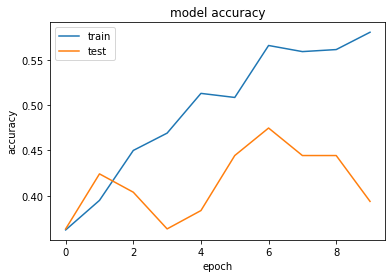

In [110]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

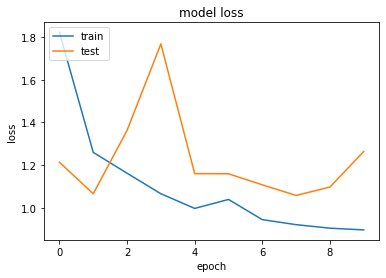

In [111]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Autoencoders

Het doel is om noise uit images weg te krijgen. Dit wordt gedaan m.b.v. autoencoders.

In [9]:
def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

In [10]:
train_data_noisy = add_noise_and_clip_data(X_train)
test_data_noisy = add_noise_and_clip_data(X_test)

In [23]:
X_train.shape

(990, 128, 128, 3)

In [24]:
train_data_noisy.shape

(990, 128, 128, 3)

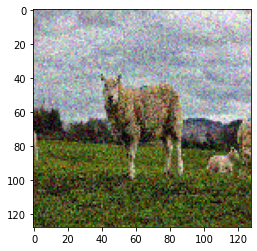

In [167]:
plt.imshow(train_data_noisy[13])

In [161]:
# Encoder
encoder_input = Input((128, 128, 3), name = 'encoder_input')

x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(encoder_input)
x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
x = MaxPooling2D((2,2), padding='same', name='pool2')(x)


In [162]:
# Decoder
x = Conv2DTranspose(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
x = UpSampling2D((2,2), name='upsample1')(x)
x = Conv2DTranspose(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
x = UpSampling2D((2,2), name='upsample2')(x)
x = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same', name='Conv7')(x)

In [155]:
# Model
autoencoder = Model(inputs=encoder_input, outputs=x)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [171]:
autoencoder.fit(train_data_noisy, X_train, epochs=10, batch_size=32, validation_split=0.1)

Train on 891 samples, validate on 99 samples
Epoch 1/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5392 - val_loss: 0.5314
Epoch 2/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5392 - val_loss: 0.5313
Epoch 3/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5400 - val_loss: 0.5327
Epoch 4/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5396 - val_loss: 0.5314
Epoch 5/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5393 - val_loss: 0.5312
Epoch 6/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5390 - val_loss: 0.5310
Epoch 7/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5391 - val_loss: 0.5310
Epoch 8/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5391 - val_loss: 0.5313
Epoch 9/10
891/891 [==============================] - 6s 7ms/sample - loss: 0.5389 - val_loss: 0.5308
Epoch 10/10
891/891 [================

In [172]:
pred = autoencoder.predict(test_data_noisy[:5])

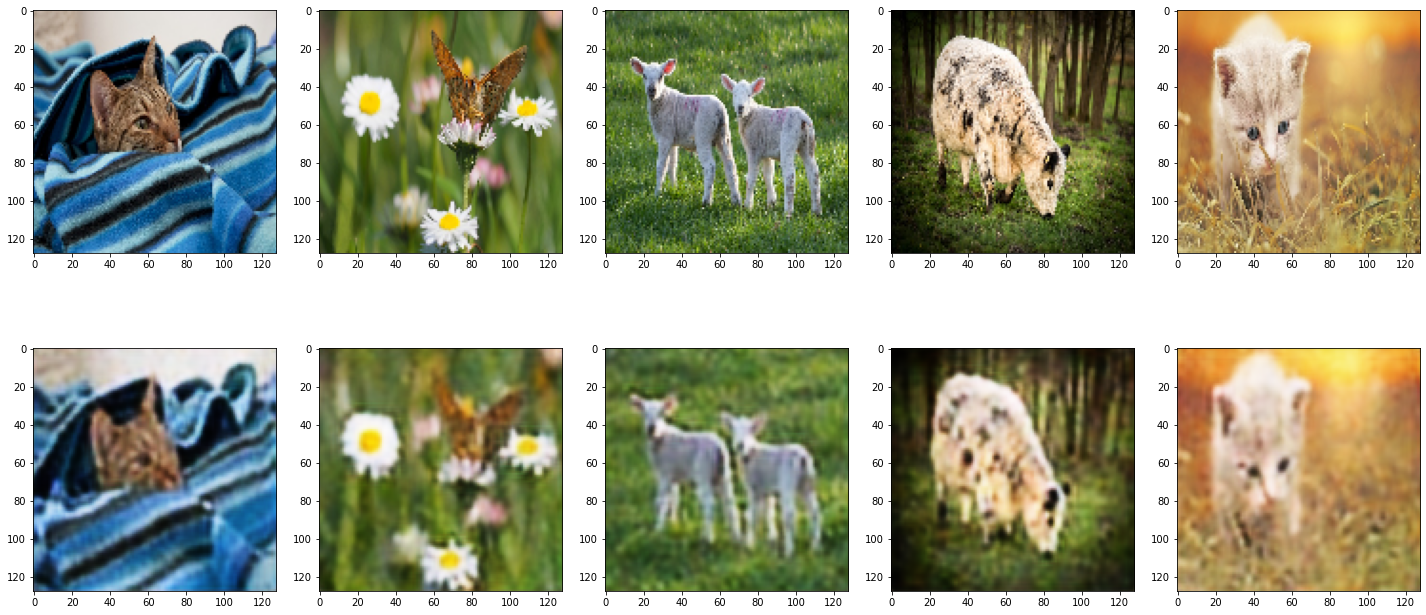

In [173]:
f, ax = plt.subplots(2, 5)
f.set_size_inches(20,10)

for i in range(5):
    ax[0][i].imshow(X_test[i])
    ax[1][i].imshow(pred[i])

plt.tight_layout()


<mark>Insights</mark>

- De decoders zijn nog steeds noisy

### Conclusie

DE CNN model doet het veel beter dan een normale Dense neurale netwerk. Dit was ook wel te verwachten. De Dense netwerk is wel heel wat sneller qua trainen.

Bij beide modellen is er sprake van overfitting. Misschien kan het handig zijn om nog even te spelen met het aantal neuronen en aantal Conv2D layers. Een percentage is 78 accuracy is niet verkeerd. Toch denk ik dat het beter kan als we de model optimaliseren.

Bij het denoisen is er nog steeds noise. Waarschijnlijk is het niet goed genoeg getrained om de noise eruit te kunnen halen. Misschien ook wat meer lagen toevoegen om het beter werkend te krijgen.

GPU geeft wat betere resultaat dan CPU. Bovendien is het ook veel sneller qua trainen. 